In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from collections import defaultdict

from IPython.display import HTML
from IPython.display import display_html

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
from utils.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [207]:
def pretty_print(df):
    return display( HTML( df.to_html(index=False).replace("\\n","<br>") ) )

In [302]:
CLUSTERS = ["cosmos08", "cosmos09", "cosmos14", "cosmos15"]
#CLUSTERS = ["cosmos08", "cosmos09", "cosmos14"]
#CLUSTERS = ["cosmos09", "cosmos15"]

FN_TMP = "../data/{CLUSTER}/op_df.csv"
FN_TMP2 = "../data/{CLUSTER}/expr_df.csv"
#DEDUPFN = FN.replace(".ss.csv", "-dedup.ss.csv")
#AUGMENTED_FN = FN.replace(".ss.csv", "-augmented.ss.csv")

INP_FIELD = "NormInputHashCode"
FILTER_FIELD = "FilterExpr"

#WKS = ["job", "tpcds", "tpch", "stack"]
WKS = ["job", "tpcds1", "tpch1", "stack", "ceb"]

WORKLOADS = {}
WORKLOADS["stack"] = "../data/stack/dfs"
WORKLOADS["tpcds"] = "../data/tpcds/all/dfs/"
WORKLOADS["tpcds1"] = "../data/tpcds1/all/dfs/"
WORKLOADS["job"] = "../data/job/all_job/sqls/dfs/"
WORKLOADS["tpch"] = "../data/tpch/all/dfs"
WORKLOADS["tpch1"] = "../data/tpch1/all/dfs"
WORKLOADS["ceb"] = "../data/ceb-all/sqls/dfs/"


EXPRDF_FIELDS = ['jobid', 'input', 'unique_filter_cols',
       'discrete_ops', 'cont_ops', 'like_ops', 'num_unique_ops', 'num_ops',
       'num_discrete_consts', 'num_likes', 'like_lens', 
        'workload', 
        'db', 'cluster', "StageName",
        'InputCardinality', 'RowCount', 'Selectivity',
        'ExclusiveTime', 'QError', 'VertexCount', 'EstCardinality',
        'cont_type',  'unique_filter_cols2', 'num_unique_ops', 'types_all', 'num_like_cols',
       'num_likes', 'like_lens', 'like_dtype', 'like_kind',
       'num_discrete_consts', 'discrete_type', 'in_ops', 'cont_dtype',
       'cont_type', 'cont_range', 'types_all'
        ]


OPDF_FIELDS = ['op', 'dtype', 'optype', 'constant', 'input', 'column', 'opstring',
       'jobid', 'exprhash', 'StageName',
       'workload', 'cluster',
        'db']

#DSCOLORS = ["blue", "red", "green", "black"]
DSCOLORS = {}
DSCOLORS["tpcds"] = "red"
DSCOLORS["tpcds1"] = "red"
DSCOLORS["tpch"] = "purple"
DSCOLORS["tpch1"] = "purple"

DSCOLORS["job"] = "green"
DSCOLORS["ceb"] = "orange"
DSCOLORS["stack"] = "blue"
DSCOLORS["cosmos"] = "grey"

In [303]:
opdfs = []
exprdfs = []

for cluster in CLUSTERS:
    print(cluster)
    #fn = FN_TMP.format(CLUSTER=cluster)
    #opdfs.append(pd.read_csv(fn, usecols = OPDF_FIELDS0))
    
    fn2 = FN_TMP2.format(CLUSTER=cluster)
    exprdfs.append(pd.read_csv(fn2, usecols = EXPRDF_FIELDS))

cosmos08


ValueError: Usecols do not match columns, columns expected but not found: ['exprhash']

In [210]:
exprdf = pd.concat(exprdfs)

In [211]:
exprdf.keys()

Index(['jobid', 'EstCardinality', 'InputCardinality', 'RowCount',
       'Selectivity', 'ExclusiveTime', 'StageName', 'VertexCount', 'QError',
       'like_ops', 'discrete_ops', 'cont_ops', 'num_ops', 'unique_filter_cols',
       'unique_filter_cols2', 'num_unique_ops', 'types_all', 'num_like_cols',
       'num_likes', 'like_lens', 'like_dtype', 'like_kind',
       'num_discrete_consts', 'discrete_type', 'in_ops', 'cont_dtype',
       'cont_type', 'cont_range', 'db', 'cluster', 'workload', 'input'],
      dtype='object')

In [212]:
def qerr(val1, val2):
    val1 = max(1, val1)
    val2 = max(1, val2)
    q = max (float(val1)/val2, float(val2)/val1)
    return q

In [213]:
exprdf["RowCount"] += 1
exprdf["EstCardinality"] += 1
exprdf["QError"] = exprdf.apply(lambda x: qerr(x["RowCount"], x["EstCardinality"]) , axis=1)
exprdf["NormTime1"] = exprdf.apply(lambda x: x["ExclusiveTime"] / x["RowCount"] ,axis=1)
exprdf["NormTime2"] = exprdf.apply(lambda x: x["ExclusiveTime"]*x["VertexCount"] / x["RowCount"] ,axis=1)

In [214]:
exprdf["Stage1"] = exprdf.apply(lambda x: "SV1_" in str(x["StageName"]) ,axis=1)
exprdf1 = exprdf[exprdf["Stage1"] == True]

In [215]:
exprdf["VertexCount"] += 1
#exprdf1["VertexCount"] += 1

#exprdf["NormTime3"] = exprdf.apply(lambda x: x["ExclusiveTime"] / x["VertexCount"] * x["RowCount"] ,axis=1)
exprdf1["NormTime3"] = exprdf1.apply(lambda x: x["ExclusiveTime"] / (x["VertexCount"] * x["RowCount"]) ,axis=1)

/tmp/ipykernel_3451209/1064147131.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exprdf1["NormTime3"] = exprdf1.apply(lambda x: x["ExclusiveTime"] / (x["VertexCount"] * x["RowCount"]) ,axis=1)


In [220]:
dbcounts1 = exprdf1.groupby("db").count()["jobid"].reset_index().sort_values(by="jobid", ascending=False)
seldbs = dbcounts1[dbcounts1["jobid"] >= 10]["db"].values
print(len(seldbs))
#dbcounts["jobid"].describe(percentiles=[0.9,0.99])

1004


In [216]:
#STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount", "exploratory_job", "templated_job"]
STATSTODROP = ["std", "min", "max"]
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "InputCardinality"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
#curdrops.append(tuple(["VertexCount","mean"]))
#print(curdrops)
pretty_print(exprdf.groupby(["cont_ops", "discrete_ops","like_ops"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE"}).\
     drop(columns=curdrops).round(2))

In [217]:
pretty_print(exprdf1.groupby(["cont_ops", "discrete_ops","like_ops"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().\
     sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE"}).\
     drop(columns=curdrops).round(4))

In [170]:
exprdf1.groupby(["cluster","cont_ops", "discrete_ops","like_ops"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().\
     drop(columns=curdrops).round(2).\
     set_index(["cluster", "cont_ops","discrete_ops","like_ops"])

ExclusiveTime                     \
                                                count       mean     50%   
cluster  cont_ops discrete_ops like_ops                                    
cosmos08 0        0            1               1846.0   40145.93   20.87   
                  1            0              27186.0    7949.82    0.11   
                               1                573.0  110544.99    0.84   
         1        0            0               9001.0    2344.12    0.02   
                               1                 95.0      92.47    0.47   
                  1            0               2526.0   10341.27    1.69   
                               1                 42.0  432777.80   73.18   
cosmos09 0        0            1                699.0    2251.68    3.52   
                  1            0              10758.0    7915.60    0.02   
                               1              12377.0     102.84    0.00   
         1        0            0               7535.0    6538.61    0.05   
                               1                 81.0    2000.05   39.26   
                  1            0               1637.0    1664.63    0.02   
                               1                103.0     750.15    0.16   
cosmos14 0        0            1                186.0   25742.46   35.68   
                  1            0              14176.0    1104.58    0.00   
                               1                235.0    7116.14   73.12   
         1        0            0               1562.0    6897.39    1.87   
                               1                  7.0    7470.29  522.57   
                  1            0                613.0   11285.02   12.00   
                               1                 49.0    8735.17    5.71   
cosmos15 0        0            1                303.0    6551.98   13.25   
                  1            0              13448.0    3068.41    0.22   
                               1                475.0   10943.04    0.51   
         1        0            0              24656.0     967.16    7.36   
                               1                286.0     128.71   41.57   
                  1            0               8876.0     382.16    0.94   
                               1                721.0    1590.53    0.36   

                                                                Selectivity  \
                                                90%         99%        mean   
cluster  cont_ops discrete_ops like_ops                                       
cosmos08 0        0            1            6035.83  1379577.81        0.15   
                  1            0             134.66    23663.01        0.22   
                               1           15227.27  1070121.06        0.06   
         1        0            0             211.09    43421.73        0.19   
                               1              39.06     1512.17        0.18   
                  1            0             179.31    77079.86        0.05   
                               1         1126073.08  1178857.13        0.11   
cosmos09 0        0            1             579.66    61415.55        0.16   
                  1            0             185.16    79312.00        0.12   
                               1               0.02       20.03        0.04   
         1        0            0             211.33     7506.86        0.50   
                               1            4247.60    36480.48        0.15   
                  1            0            1014.43    29509.21        0.06   
                               1               4.68    12354.41        0.04   
cosmos14 0        0            1           45327.18   533777.12        0.05   
                  1            0              16.32     7417.38        0.04   
                               1           10722.01   144759.67        0.04   
         1        0            0             957.66   334961.79        0.34   
                        

In [171]:
exprdf1.keys()

Index(['jobid', 'EstCardinality', 'InputCardinality', 'RowCount',
       'Selectivity', 'ExclusiveTime', 'StageName', 'VertexCount', 'QError',
       'like_ops', 'discrete_ops', 'cont_ops', 'num_ops', 'unique_filter_cols',
       'unique_filter_cols2', 'num_unique_ops', 'types_all', 'num_like_cols',
       'num_likes', 'like_lens', 'like_dtype', 'like_kind',
       'num_discrete_consts', 'discrete_type', 'in_ops', 'cont_dtype',
       'cont_type', 'cont_range', 'db', 'cluster', 'workload', 'input',
       'NormTime1', 'NormTime2', 'Stage1', 'NormTime3'],
      dtype='object')

In [172]:
tmp = exprdf1[['InputCardinality', 'RowCount',
       'Selectivity', 'ExclusiveTime',
       #'VertexCount', 'QError',
       #'like_ops', 'discrete_ops', 'cont_ops', 'num_ops', 'unique_filter_cols',
       #'NormTime1', 'NormTime2'
       ]].reset_index(drop=True).sample(frac=0.001)

In [226]:
def get_filter_group(x):
    grp = ""
    if x["discrete_ops"]:
        grp += "discrete"
    if x["cont_ops"]:
        grp += "cont"
    if x["like_ops"]:
        grp += "like"

    return grp

In [227]:
exprdf1["FilterGroup"] = exprdf1.apply(lambda x: get_filter_group(x),axis=1)

/tmp/ipykernel_3451209/472425133.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exprdf1["FilterGroup"] = exprdf1.apply(lambda x: get_filter_group(x),axis=1)


In [224]:
exprdf1.groupby(["FilterGroup"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().\
     drop(columns=curdrops).round(2)

FilterGroup ExclusiveTime                                        \
                              count      mean    50%      90%         99%   
0               cont,       42754.0   2455.63   0.47   688.16    31936.89   
1           cont,like         469.0    554.14  33.24   339.53     5502.46   
2           discrete,       65568.0   5463.06   0.05   128.50    26346.08   
3      discrete,cont,       13652.0   2868.21   0.89   171.43    32045.89   
4  discrete,cont,like         915.0  21670.74   0.55  1542.34  1103356.82   
5       discrete,like       13660.0   5233.19   0.00     0.02     5550.20   
6                like        3034.0  27177.54  11.44  6484.28   510577.82   

  Selectivity                       QError                             \
         mean   50%   90%   99%        50%          90%           99%   
0        0.31  0.08  1.00  1.00      12.06       610.54  2.195936e+07   
1        0.19  0.02  0.41  1.00      25.02   2052479.10  5.082856e+08   
2        0.19  0.01  1.00  1.00      60.18  60571101.00  3.570928e+09   
3        0.20  0.01  0.73  1.00      38.59   2535006.00  1.478068e+09   
4        0.04  0.00  0.05  1.00  168799.15   7243041.00  8.226542e+07   
5        0.04  0.00  0.00  0.97  167002.00   2641681.00  7.140096e+07   
6        0.14  0.01  0.51  1.00     100.38  14582501.00  4.622141e+10   

  InputCardinality                                           
              mean          50%           90%           99%  
0     1.558095e+10   41855300.0  5.657930e+09  2.800028e+11  
1     4.817471e+10   75868300.0  4.013252e+10  6.102832e+11  
2     3.255824e+10   20639900.0  4.649697e+09  8.924190e+11  
3     2.548126e+10  128317500.0  6.883206e+09  6.059710e+11  
4     1.505363e+11   89784400.0  3.419310e+10  7.818515e+12  
5     1.864046e+10    1486930.0  2.006220e+07  2.440341e+11  
6     1.191652e+11  163558500.0  2.608322e+10  4.110260e+12

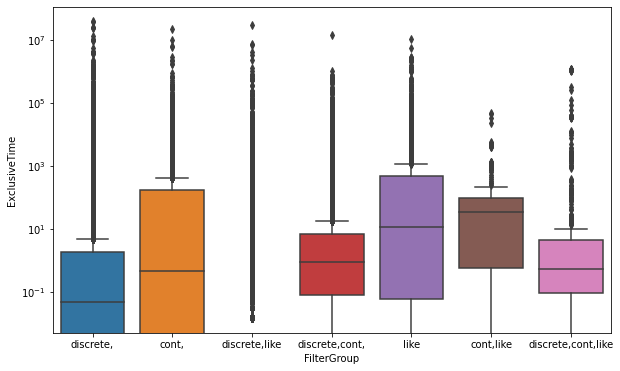

In [176]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.boxplot(data=exprdf1, x="FilterGroup", y="ExclusiveTime",ax=ax)
plt.yscale("log")
#plt.ylim([1e2,1e7])

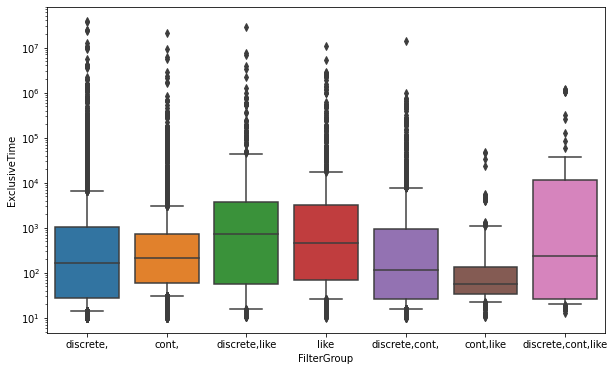

In [177]:
tmp = exprdf1[exprdf1["ExclusiveTime"] >= 10.0]
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.boxplot(data=tmp, x="FilterGroup", y="ExclusiveTime", whis=[10,90],ax=ax)
plt.yscale("log")

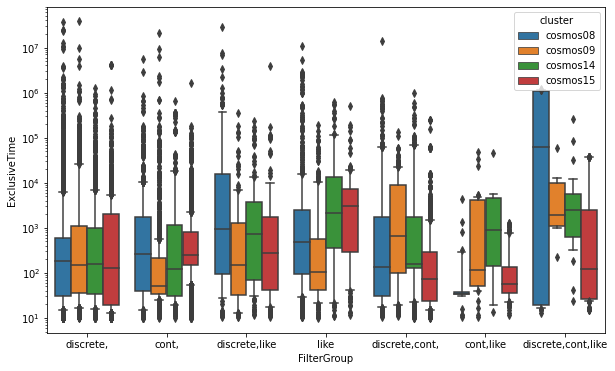

In [178]:
tmp = exprdf1[exprdf1["ExclusiveTime"] >= 10.0]
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.boxplot(data=tmp, x="FilterGroup", y="ExclusiveTime", hue="cluster", whis=[10,90],ax=ax)
plt.yscale("log")

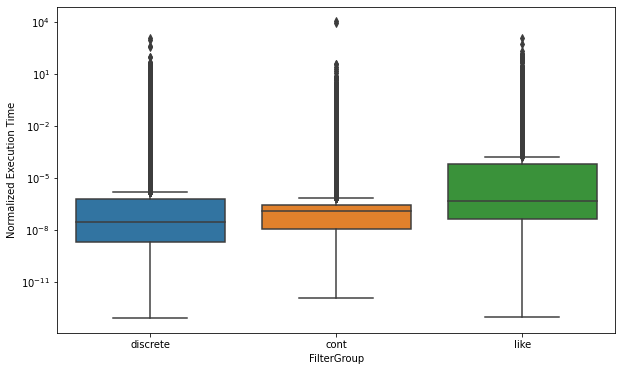

In [296]:
tmp = exprdf1[exprdf1["ExclusiveTime"] >= 1.0]
tmp = tmp[tmp["FilterGroup"].isin(["discrete", "cont", "like"])]
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.boxplot(data=tmp, x="FilterGroup", y="NormTime3",ax=ax)
plt.ylabel("Normalized Execution Time")
plt.yscale("log")
plt.savefig("FilterGroup-vs-NormalizedExecutionTime.pdf")

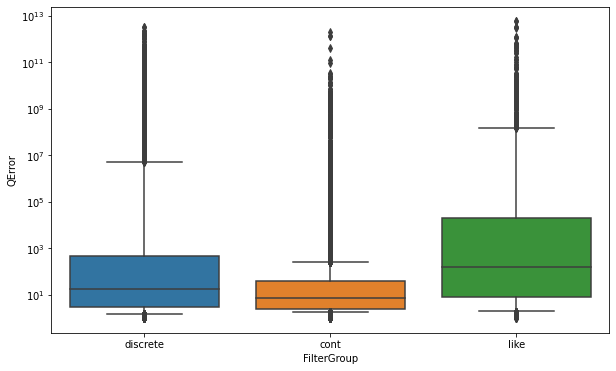

In [299]:
#tmp = exprdf1[exprdf1["ExclusiveTime"] >= 1.0]
tmp = tmp[tmp["FilterGroup"].isin(["discrete", "cont", "like"])]
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.boxplot(data=tmp, x="FilterGroup", y="QError", whis=[10,90],ax=ax)
#plt.ylabel("Normalized Execution Time")
#plt.ylim([1,1e9])
plt.yscale("log")
plt.savefig("FilterGroup-vs-QError.pdf")

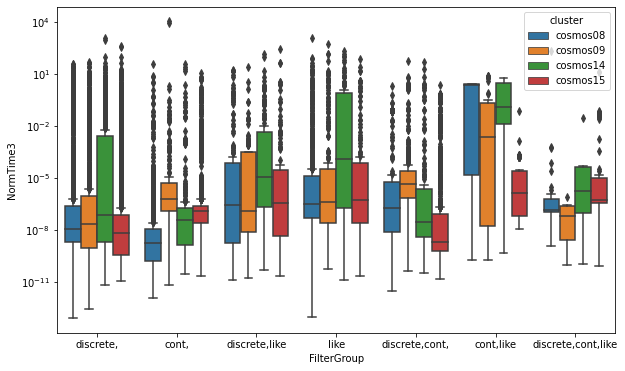

In [180]:
tmp = exprdf1[exprdf1["ExclusiveTime"] >= 10.0]
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.boxplot(data=tmp, x="FilterGroup", y="NormTime3", hue="cluster", ax=ax)
plt.yscale("log")

/tmp/ipykernel_3451209/2131332954.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,1e9])


(0.2301691454523236, 1000000000.0)

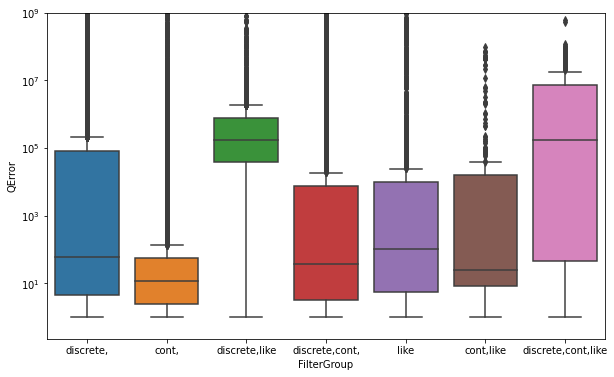

In [181]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.boxplot(data=exprdf1, x="FilterGroup", y="QError", whis=1.5, ax=ax)
plt.yscale("log")
plt.ylim([0,1e9])

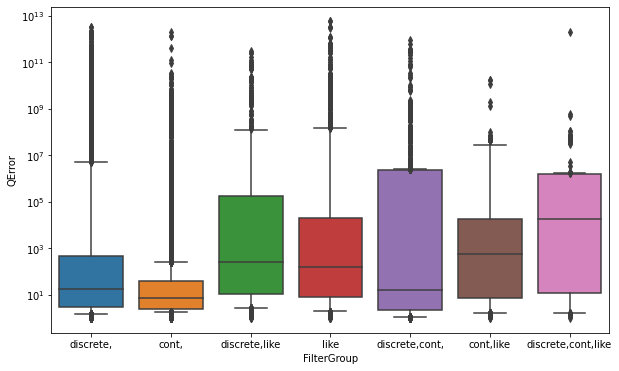

In [182]:
tmp = exprdf1[exprdf1["ExclusiveTime"] >= 1.0]
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.boxplot(data=tmp, x="FilterGroup", y="QError", whis=[10,90], ax=ax)
plt.yscale("log")

# Figure 2

In [238]:
#STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount", "exploratory_job", "templated_job"]
STATSTODROP = ["std", "min", "max"]
STATCOLS = ["ExclusiveTime", "NormTime3", "Selectivity", "QError"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
#curdrops.append(tuple(["VertexCount","mean"]))
#print(curdrops)
pretty_print(exprdf1.groupby(["unique_filter_cols"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().\
     #.sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE"}).\
     drop(columns=curdrops).round(2))

# Continuous filter description

In [241]:
dfcont = exprdf1[exprdf1.cont_ops == 1]
dfcont = dfcont[dfcont["cont_dtype"].isin(["date", "int", "float"])]

In [250]:
STATCOLS = ["NormTime3", "Selectivity", "QError"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfcont.groupby(["cont_type"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     drop(columns=curdrops).round(2).\
     rename(columns={"cont_type":"Continuous Operator \\n Type", "NormTime3":"Normalized Execution Time"})
     )

In [251]:
#STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]

STATCOLS = ["NormTime3", "Selectivity", "QError"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))
curdrops.append(tuple(["QError","mean"]))

pretty_print(dfcont.groupby(["cont_dtype"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     drop(columns=curdrops).round(2).\
     rename(columns={"cont_type":"Continuous Operator \\n Type", "NormTime3":"Normalized Execution Time"}
           ))

In [260]:
dfnodate = dfcont[dfcont.cont_dtype != "date"]
pretty_print(dfnodate.groupby(["cont_type"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     drop(columns=curdrops).round(2).\
     rename(columns={"cont_type":"Continuous Operator \\n Type", "NormTime3":"Normalized Execution Time"})
     )

In [263]:
dfcont.groupby(["cont_dtype", "cont_type"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().\
     set_index(["cont_dtype", "cont_type"]).\
     drop(columns=curdrops).round(2).\
     rename(columns={"cont_type":"Continuous Operator \\n Type", "NormTime3":"Normalized Execution Time"}
           )

Normalized Execution Time                          \
                                         count  mean   50%   90%   99%   
cont_dtype cont_type                                                     
date       discont                      1920.0  1.39  1.85  2.16  2.81   
           gt                          15911.0  0.01  0.00  0.00  0.15   
           lt                           5021.0  0.00  0.00  0.00  0.00   
           range                       14197.0  0.01  0.00  0.00  0.04   
float      discont                        65.0  0.00  0.00  0.00  0.00   
           gt                            670.0  0.00  0.00  0.00  0.02   
           lt                            195.0  0.00  0.00  0.00  0.00   
           range                          75.0  0.00  0.00  0.00  0.00   
int        discont                       248.0  0.02  0.00  0.00  0.57   
           gt                          13295.0  0.02  0.00  0.00  0.08   
           lt                           2213.0  0.03  0.00  0.00  0.02   
           range                        1052.0  0.01  0.00  0.00  0.02   

                     Selectivity                        QError              \
                            mean   50%   90%   99%         50%         90%   
cont_dtype cont_type                                                         
date       discont          0.06  0.00  0.03  1.00  2432281.00  2550774.00   
           gt               0.34  0.08  1.00  1.00        6.25      617.09   
           lt               0.79  1.00  1.00  1.00        8.50       35.00   
           range            0.07  0.00  0.20  1.00       91.31  1346525.10   
float      discont          0.30  0.10  0.87  0.91        5.57       64.93   
           gt               0.27  0.07  1.00  1.00        9.53     3831.60   
           lt               0.33  0.11  1.00  1.00        6.18     1622.44   
           range            0.23  0.02  0.92  1.00       23.06    34994.82   
int        discont          0.19  0.04  0.62  1.00        9.98     2720.73   
           gt               0.25  0.10  0.72  1.00        6.26      174.16   
           lt               0.40  0.32  1.00  1.00        3.65      603.71   
           range            0.33  0.19  1.00  1.00        4.35      500.50   

                                    
                               99%  
cont_dtype cont_type                
date       discont    2.578270e+06  
           gt         1.168827e+09  
           lt         4.301800e+02  
           range      5.148324e+08  
float      discont    4.044010e+03  
           gt         6.630100e+07  
           lt         1.003140e+08  
           range      3.267281e+11  
int        discont    6.268343e+08  
           gt         2.506500e+08  
           lt         6.303249e+07  
           range      1.428145e+11

In [198]:
dfr = exprdf1[exprdf1.cont_range > 0.0]
dfr["cont_range_days"] = dfr.apply(lambda x: x["cont_range"] / 86400 ,axis=1)

/tmp/ipykernel_3451209/1455277342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfr["cont_range_days"] = dfr.apply(lambda x: x["cont_range"] / 86400 ,axis=1)


<AxesSubplot:xlabel='cont_range_days'>

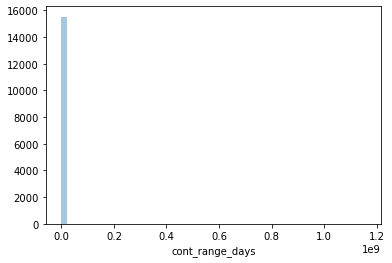

In [202]:
sns.distplot(dfr["cont_range_days"], kde=False)
#plt.xscale("log")

In [204]:
HTML(dfr.groupby(["cluster"])["cont_range_days"].describe(percentiles=[0.25, 0.40,
                            0.6, 0.75, 0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

cluster,count,mean,std,min,25%,40%,50%,60%,75%,90%,99%,max
cosmos15,8693.0,1.333284e+05,1.241370e+07,3.472222e-06,1.367119,7.000000,30.000000,55.958333,56.000000,361.911089,2.188732e+03,1.157407e+09
cosmos09,3242.0,1.788664e+00,1.408165e+01,2.314815e-07,0.027766,0.027778,0.027778,0.041667,0.041667,0.041667,7.774167e+01,3.650000e+02
cosmos08,2708.0,8.416204e+06,7.720861e+07,1.157407e-08,0.041655,0.041655,0.041655,0.041667,0.625000,91.041655,7.500000e+08,7.500000e+08
cosmos14,894.0,9.920359e+01,2.810365e+02,5.787037e-07,1.000000,5.000000,13.000000,24.000000,31.000000,336.958333,1.435000e+03,1.435000e+03


# Discrete

# LIKE

In [252]:
dflikes = exprdf1[exprdf1["like_ops"] == 1]

In [253]:
pretty_print(dflikes.groupby(["unique_filter_cols"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
                  drop(columns=curdrops).\
     rename(columns={"like_lens":"Filter Length"}).\
     round(2))

In [254]:
pretty_print(dflikes.groupby(["num_likes"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("num_likes"), ascending=True).\
                  drop(columns=curdrops).\
     rename(columns={"like_lens":"Filter Length"}).\
     round(2))

In [301]:
pretty_print(dflikes.groupby(["like_kind"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
                  drop(columns=curdrops).\
     rename(columns={"like_lens":"Filter Length", "NormTime3":"Normalized Execution Time"}).\
     round(2))

# Multi-Dimensional Stuff

In [268]:
types_all = set(exprdf1["types_all"].values)
new_types_all = set()
for t in types_all:
    #t2 = t.replace("null,", "")
    if "null" in t:
        continue
    if t.count(",") == 1:
        new_types_all.add(t)

df2 = exprdf1[exprdf1.types_all.isin(new_types_all)]
# HTML(df2.groupby(["types_all"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).round(2).to_html(index=False))

STATCOLS = ["NormTime3", "Selectivity", "QError"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))
curdrops.append(tuple(["QError","mean"]))

pretty_print(df2.groupby(["types_all"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_type":"Continuous Operator \\n Type"}).\
     drop(columns=curdrops).round(3))

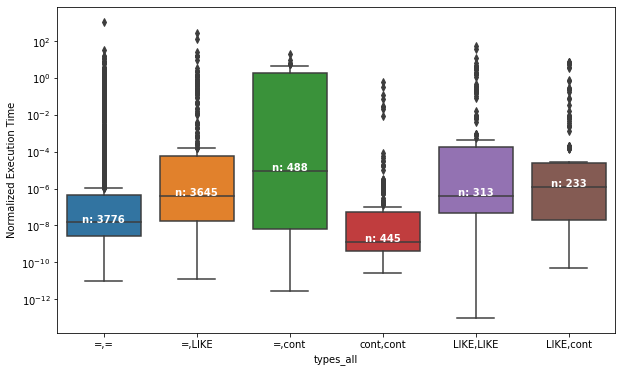

In [295]:
tmp = df2[df2["ExclusiveTime"] >= 1.0]
#tmp = tmp[tmp["types_all"].isin(["discrete", "cont", "like"])]
#order = tmp["types_all"]

order = ['=,=', '=,LIKE', '=,cont', 'cont,cont', 'LIKE,LIKE', 'LIKE,cont']

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.boxplot(data=tmp, x="types_all", y="NormTime3",ax=ax, order=order)

#medians = tmp.groupby(['types_all'])['NormTime3'].median().values
#print(medians)
medians = []
for o in order:
    tmp2 = tmp[tmp["types_all"] == o]
    medians.append(tmp2["NormTime3"].median())

nobs = tmp['types_all'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            medians[tick],
            nobs[tick],
            horizontalalignment='center',
            size='medium',
            color='w',
            weight='bold')
    
plt.ylabel("Normalized Execution Time")
plt.yscale("log")

plt.savefig("2d-vs-NormalizedExecutionTime.pdf")

In [287]:
set(tmp["types_all"].values)

{'=,=', '=,LIKE', '=,cont', 'LIKE,LIKE', 'LIKE,cont', 'cont,cont'}